# Machine Learning Engineer Nanodegree
## Capstone Project
## Predicting Ames Houses on the Entire Feature Set

The ultimate goal of this project is to predict how much a house should be solved in Ames, IA.
The problem is a standing [Kaggle Competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). The dataset contains a list of information for all houses sold in Ames, Iowa from 2006 through 2010. It contains **2930** observations and a large number of explanatory
variables (**23 nominal, 23 ordinal, 14 discrete, and 20 continuous**). Dean De Cook compiled and published this dataset in 2011 and can be found here [here](http://www.amstat.org/publications/jse/v19n3/decock.pdf). 

With the entry Id removed, the dataset is described by 304 features, after transformation of the categoricals to dummy variables.

## I . Import necessary modules.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(font_scale=1.5) 
sns.set_style("white")

# Pretty display for notebooks
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as grd
import matplotlib.ticker as tkr
import matplotlib.font_manager as font_manager

from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import FuncFormatter
from matplotlib import rcParams

#define plotter
minorLocatorx   = AutoMinorLocator(10)
minorLocatory   = AutoMinorLocator(4)
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
matplotlib.rcParams['axes.linewidth'] = 2.
plt.rcParams['axes.linewidth'] = 4
plt.rc('font', family='serif')
plt.rc('font', serif='Times New Roman') 
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size
 

## II. Load the dataset and drop the unnecessary sample ID.

In [2]:
# Load the Ames housing dataset. This will have to be split for evaluation!
data = pd.read_csv('train.csv')
data = data.drop(['Id'], axis=1)
# Success
print "Ames housing dataset has {} data points with {} variables each.".format(*data.shape)
print data.tail(3)

# Then load test.csv
test = pd.read_csv('test.csv')
test = test.drop(['Id'], axis=1)


Ames housing dataset has 1460 data points with 80 variables each.
      MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1457          70       RL         66.0     9042   Pave   NaN      Reg   
1458          20       RL         68.0     9717   Pave   NaN      Reg   
1459          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities LotConfig    ...     PoolArea PoolQC  Fence  \
1457         Lvl    AllPub    Inside    ...            0    NaN  GdPrv   
1458         Lvl    AllPub    Inside    ...            0    NaN    NaN   
1459         Lvl    AllPub    Inside    ...            0    NaN    NaN   

     MiscFeature MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
1457        Shed    2500      5    2010        WD         Normal     266500  
1458         NaN       0      4    2010        WD         Normal     142125  
1459         NaN       0      6    2008        WD         Normal     147500  

[3 rows x 80 columns]


## III. Define training and preprocessing functions

In [3]:
# Define functions for creating sets and training.
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

############################################## Create Train/Test Splits ##############################################
############################################## Create Train/Test Splits ##############################################

def create_sets(X, y):
    # Split into training and testing components first
    from sklearn.cross_validation import train_test_split, ShuffleSplit
    
    # Set the number of training points
    num_train = int(round(0.70*len(X)))
    
    # Set the number of testing points
    num_test = X.shape[0] - num_train
    
    # Shuffle and split the dataset into the number of training and testing points above
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = num_train, random_state=123458)
    
    # Show the results of the split
    print "Training set has {} samples.".format(X_train.shape[0])
    print "Testing set has {} samples.".format(X_test.shape[0])
    return X_train, X_test, y_train, y_test

##############################################   Model   Fitting   ##############################################
##############################################   Model   Fitting   ##############################################

# Using GridSearch CV, we fine tune the model.

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.cross_validation import cross_val_score, ShuffleSplit
from sklearn.grid_search import GridSearchCV


def fit_model(X, y, n_estimators = 1000, min_samples_leaf = 1, min_samples_split =2):
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20)
    regressor = GradientBoostingRegressor(loss= 'lad', n_estimators=n_estimators,min_samples_leaf = 1, 
                                          min_samples_split =2,random_state=102345)

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'learning_rate': [0.01, 0.02, 0.05, 0.1], # 'n_estimators': [100, 500, 1000],
              'max_depth': [2, 3, 4, 5, 6], 'min_samples_leaf':  [2,3,5,7]}
    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)
    # Create the grid search object
    grid = GridSearchCV(regressor, params, cv=cv_sets, scoring = scoring_fnc)#, verbose=10)
    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)
    # Print the optimal model after fitting the data
    print 'The cross-validation scores = {:.2f}'.format(grid.best_score_)
    print grid.best_estimator_
    return grid

In [4]:
#Make dummies for categorical features.
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():

        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'GarageCond' => 'GarageCond_Ex', etc.
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

In [5]:
def remove_nans(df):
    nan_df = df[pd.isnull(df).any(axis=1)]
    for col in nan_df.columns:
        tmp = nan_df[col][pd.isnull(nan_df[col])]
        if len(tmp) >= 1:
            #print "These features have NULLs to signify the absence of such a feature:"
            print col, len(tmp)
            df[col] = df[col].fillna(1.)
    print np.shape(df)
    return df

# <center/> IV. Process and Train data.

 ## <center> 4. Preprocessing training set WITH REPEAT OUTLIERS

# <center> 4.1 Removing outliers NOW!

### Using [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal. 

## 4.2.1 Define function that removes REPEAT outliers. 

Consider as outliers only for those which are continuous variables.

In [6]:
## Try to remove outliers
# For each feature in out_columns find the data points with extreme high or low values
def remove_outliers(df):
    outliers  = []
    out_columns = ['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea', 
                   'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'SalePrice', '1stFlrSF', 
                   "2ndFlrSF", "ScreenPorch", "PoolArea", '3SsnPorch', "MiscVal", "EnclosedPorch",
                   'BsmtFinSF2','LowQualFinSF', "BsmtUnfSF", 'LotFrontage']
    for feature in out_columns:
        
        # Calculate Q1 (25th percentile of the data) for the given feature
        Q1 = np.percentile(df[feature], 25)
        
        # Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = np.percentile(df[feature], 75)
        
        # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
        step = 1.5*(Q3-Q1)
        
        outliers = list(outliers + df[~((df[feature] >= Q1 - step) & \
                                                  (df[feature] <= Q3 + step))].index.tolist())
    
    # Select the indices for data points you wish to remove
    from collections import Counter
    counts = Counter(outliers)
    outliers = sorted([value for value, count in counts.items() if count > 2])
    return outliers

In [7]:
# Remove NaNs
data = remove_nans(data)
data = preprocess_features(data)
# Remove outliers
outliers = remove_outliers(data)
good_data = data.drop(data.index[outliers]).reset_index(drop = True)
good_data_X = good_data[good_data.columns[:-1]]
good_data_y =  good_data[good_data.columns[-1]]
print "The dimensions of the data without outliers now is {}".format(np.shape(good_data_X))


LotFrontage 259
Alley 1369
MasVnrType 8
MasVnrArea 8
BsmtQual 37
BsmtCond 37
BsmtExposure 38
BsmtFinType1 37
BsmtFinType2 38
Electrical 1
FireplaceQu 690
GarageType 81
GarageYrBlt 81
GarageFinish 81
GarageQual 81
GarageCond 81
PoolQC 1453
Fence 1179
MiscFeature 1406
(1460, 80)
The dimensions of the data without outliers now is (1378, 304)


In [8]:
print "Processed feature columns ({} total features):\n{}".format(len(good_data_X.columns), list(good_data_X.columns))
print np.shape(good_data_X)

Processed feature columns (304 total features):
['MSSubClass', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'LotFrontage', 'LotArea', 'Street_Grvl', 'Street_Pave', 'Alley_1.0', 'Alley_Grvl', 'Alley_Pave', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'Utilities_AllPub', 'Utilities_NoSeWa', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighb

> ## Feature size ballooned to 304.

## 4.1.3 Preprocessing testing set...

In [9]:
test_data = remove_nans(test)
test_X_all = preprocess_features(test_data)
print np.shape(test_X_all)

MSZoning 4
LotFrontage 227
Alley 1352
Utilities 2
Exterior1st 1
Exterior2nd 1
MasVnrType 16
MasVnrArea 15
BsmtQual 44
BsmtCond 45
BsmtExposure 44
BsmtFinType1 42
BsmtFinSF1 1
BsmtFinType2 42
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
BsmtFullBath 2
BsmtHalfBath 2
KitchenQual 1
Functional 2
FireplaceQu 730
GarageType 76
GarageYrBlt 78
GarageFinish 78
GarageCars 1
GarageArea 1
GarageQual 78
GarageCond 78
PoolQC 1456
Fence 1169
MiscFeature 1408
SaleType 1
(1459, 79)
(1459, 292)


## Make the test set features compatible with the training set.


In [10]:
## Fix columns in training set first.
add_to_train_cols = list(set(test_X_all.columns) - set(good_data_X.columns))
## Append these as zeroes to the training set.
#df.insert(idx, col_name, value)
for col in add_to_train_cols:
    if col not in good_data_X.columns:
        good_data_X.insert(len(good_data_X.columns), col, 0 )
print good_data_X.head()

   MSSubClass  MSZoning_C (all)  MSZoning_FV  MSZoning_RH  MSZoning_RL  \
0          60               0.0          0.0          0.0          1.0   
1          20               0.0          0.0          0.0          1.0   
2          60               0.0          0.0          0.0          1.0   
3          70               0.0          0.0          0.0          1.0   
4          60               0.0          0.0          0.0          1.0   

   MSZoning_RM  LotFrontage  LotArea  Street_Grvl  Street_Pave  \
0          0.0         65.0     8450          0.0          1.0   
1          0.0         80.0     9600          0.0          1.0   
2          0.0         68.0    11250          0.0          1.0   
3          0.0         60.0     9550          0.0          1.0   
4          0.0         84.0    14260          0.0          1.0   

        ...         SaleCondition_Family  SaleCondition_Normal  \
0       ...                          0.0                   1.0   
1       ...               

In [11]:
## Fix the test set.
add_to_test_cols = list(set(good_data_X.columns) - set(test_X_all.columns) )
## Append these as zeroes to the testing set.
for col in add_to_test_cols:
    if col not in test_X_all.columns:
        test_X_all.insert(len(test_X_all.columns), col, 0 )
print test_X_all.columns

Index([u'MSSubClass', u'MSZoning_0.0', u'MSZoning_C (all)', u'MSZoning_FV',
       u'MSZoning_RH', u'MSZoning_RL', u'MSZoning_RM', u'LotFrontage',
       u'LotArea', u'Street_Grvl',
       ...
       u'MiscFeature_TenC', u'Condition2_RRAe', u'RoofMatl_Roll',
       u'Condition2_RRNn', u'RoofMatl_Membran', u'Condition2_RRAn',
       u'RoofMatl_Metal', u'Electrical_Mix', u'Exterior1st_ImStucc',
       u'GarageQual_Ex'],
      dtype='object', length=311)


In [12]:
test_X_all = test_X_all[good_data_X.columns]  
print list(set(test_X_all.columns) - set(good_data_X.columns))
print list(set(good_data_X.columns) - set(test_X_all.columns))
print good_data_X.columns
print test_X_all.columns
print "Now train.csv has the same columns as test.csv"

[]
[]
Index([u'MSSubClass', u'MSZoning_C (all)', u'MSZoning_FV', u'MSZoning_RH',
       u'MSZoning_RL', u'MSZoning_RM', u'LotFrontage', u'LotArea',
       u'Street_Grvl', u'Street_Pave',
       ...
       u'SaleCondition_Family', u'SaleCondition_Normal',
       u'SaleCondition_Partial', u'Utilities_0.0', u'Exterior1st_0.0',
       u'Functional_0.0', u'MSZoning_0.0', u'SaleType_0.0', u'KitchenQual_0.0',
       u'Exterior2nd_0.0'],
      dtype='object', length=311)
Index([u'MSSubClass', u'MSZoning_C (all)', u'MSZoning_FV', u'MSZoning_RH',
       u'MSZoning_RL', u'MSZoning_RM', u'LotFrontage', u'LotArea',
       u'Street_Grvl', u'Street_Pave',
       ...
       u'SaleCondition_Family', u'SaleCondition_Normal',
       u'SaleCondition_Partial', u'Utilities_0.0', u'Exterior1st_0.0',
       u'Functional_0.0', u'MSZoning_0.0', u'SaleType_0.0', u'KitchenQual_0.0',
       u'Exterior2nd_0.0'],
      dtype='object', length=311)
Now train.csv has the same columns as test.csv


## 4.1.2 Investigate learning curves

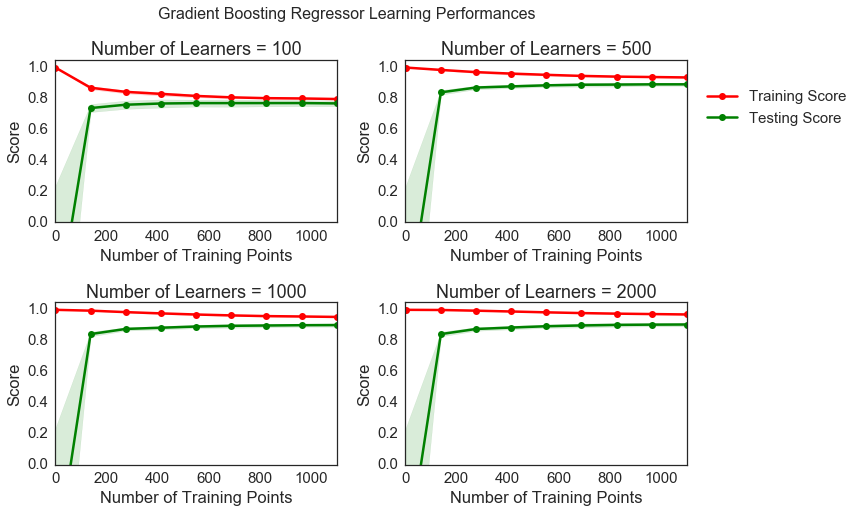

In [13]:
import visuals as vs
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_style("white")
vs.ModelLearning(good_data_X, good_data_y)


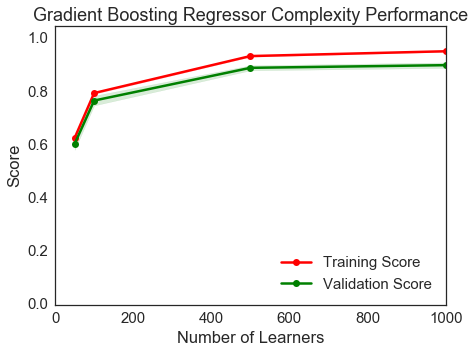

In [14]:
vs.ModelComplexity(good_data_X, good_data_y)

> ### We likely need 1000$^{ish}$ estimators. As before, we use the usual 80-20 split.

## 4.2.3 Begin training without outliers

In [ ]:
X_train_good, X_test_good, y_train_good, y_test_good = create_sets(good_data_X, good_data_y)

from time import time
start = time()
reg_good = fit_model(X_train_good, y_train_good, n_estimators=1000, min_samples_leaf = 1, min_samples_split = 10)
end = time()
print "Trained model in {:.4f} seconds".format(end-start)

Training set has 965 samples.
Testing set has 413 samples.


In [16]:
start = time()
pred_good = reg_good.predict(X_test_good)
end = time()
print "Model made predictions in {:.4f} seconds".format(end-start)

Model made predictions in 0.0107 seconds


## 4.2.4 Evaluate, validate and visualize results.

There are 247 examples for testing.

In [17]:
print 'The R$^2$ = {:.2f}'.format(r2_score(pred_good, y_test_good))
print 'The  RMSE = {:.2e}.'.format(mean_squared_error(pred_good, y_test_good))

The R$^2$ = 0.88
The  RMSE = 4.94e+08.


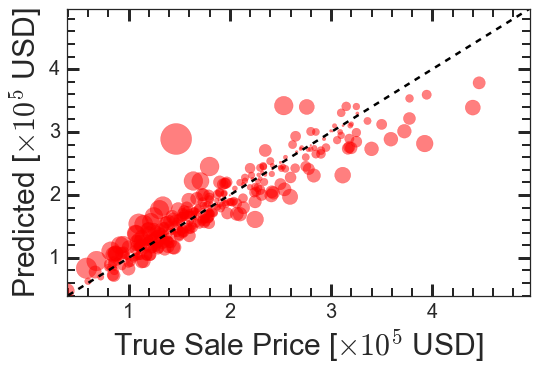

In [18]:
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
plt.scatter(y_test_good/1e5, pred_good/1e5, alpha = 0.5, s = 1000*np.abs(y_test_good-pred_good)/y_test_good, color = 'red')
plt.xlabel(r"True Sale Price [$\times 10^{5} $ USD]", fontsize = 30);
plt.ylabel(r"Predicted [$\times 10^{5} $ USD]", fontsize = 30);
plt.minorticks_on()
plt.tight_layout()
plt.plot(np.arange(0,10, 1), np.arange(0,10, 1), 'k--')
plt.tick_params('both', length=8, width=2, which='minor');
plt.tick_params('both', length=12, width=3, which='major');
plt.xlim(min([min(y_test_good), min(pred_good)])/1e5, max([max(y_test_good)-0.5, max(pred_good)])/1e5+0.5)
plt.ylim(min([min(y_test_good), min(pred_good)])/1e5, max([max(y_test_good)-0.5, max(pred_good)])/1e5+0.5)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("FinalModel_linear_all.pdf")

The mean is -0.99 and stdev of 12.34


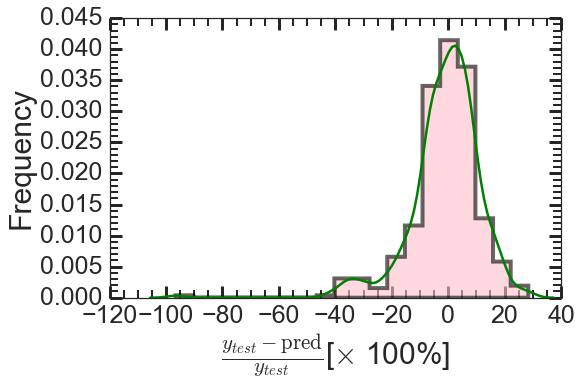

In [19]:
diff_good = (y_test_good - pred_good)/y_test_good*100.
sns.distplot(diff_good, bins=20, color='g', hist_kws={"histtype": "stepfilled", "linewidth": 4, 
                                                    "alpha": 0.60, "color": "pink"});
plt.xlabel(r"$\frac{y_{test} - \mathrm{pred} }{y_{test}}$" + r"[$ \times $ 100%]", fontsize = 30);
plt.ylabel(r"Frequency", fontsize = 30);
plt.minorticks_on()
plt.tight_layout()
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.tick_params('both', length=8, width=2, which='minor');
plt.tick_params('both', length=12, width=3, which='major');
plt.savefig('FinalDiffDist_linear_all.pdf')

print "The mean is {:.2f} and stdev of {:.2f}".format(np.mean(diff_good), np.std(diff_good))

## How does the model predict outliers?

In [34]:

# Remove NaNs
test_data_out = data.iloc[outliers, :]
test_data_out = remove_nans(test_data_out)
test_data_out = preprocess_features(test_data_out)

# Take out target
X_out = test_data_out[test_data_out.columns[:-1]]
y_out = test_data_out[test_data_out.columns[-1]]


## Fix columns in training set first.
add_to_out_cols = list(set(good_data_X.columns) - set(X_out.columns))

## Append these as zeroes to the outliers set.
for col in add_to_out_cols:
    if col not in X_out.columns:
        X_out.insert(len(X_out.columns), col, 0 )


X_out = X_out[X_test_good.columns]  
print "Now train.csv has the same columns as test.csv"

X_test_data_out_good = X_out.append(X_test_good, ignore_index=True)
y_test_data_out_good = y_out.append(y_test_good)

print 'The outliers and test set combined has {} examples'.format(np.shape(X_test_data_out_good))

(82, 305)
Now train.csv has the same columns as test.csv
The outliers and test set combined has (495, 311) examples
Index([u'MSSubClass', u'MSZoning_C (all)', u'MSZoning_FV', u'MSZoning_RH',
       u'MSZoning_RL', u'MSZoning_RM', u'LotFrontage', u'LotArea',
       u'Street_Grvl', u'Street_Pave',
       ...
       u'SaleCondition_Family', u'SaleCondition_Normal',
       u'SaleCondition_Partial', u'Utilities_0.0', u'Exterior1st_0.0',
       u'Functional_0.0', u'MSZoning_0.0', u'SaleType_0.0', u'KitchenQual_0.0',
       u'Exterior2nd_0.0'],
      dtype='object', length=311)
Index([u'MSSubClass', u'MSZoning_C (all)', u'MSZoning_FV', u'MSZoning_RH',
       u'MSZoning_RL', u'MSZoning_RM', u'LotFrontage', u'LotArea',
       u'Street_Grvl', u'Street_Pave',
       ...
       u'SaleCondition_Family', u'SaleCondition_Normal',
       u'SaleCondition_Partial', u'Utilities_0.0', u'Exterior1st_0.0',
       u'Functional_0.0', u'MSZoning_0.0', u'SaleType_0.0', u'KitchenQual_0.0',
       u'Exterior2nd_0

In [21]:
## Predict the outliers
pred_out = reg_good.predict(X_out)
print 'The R$^2$ = {:.2f}'.format(r2_score(pred_out, y_out))
print 'The  RMSE = {:.2e}.'.format(mean_squared_error(pred_out, y_out))
X_test_data_out_good[pd.isnull(X_test_data_out_good).any(axis=1)]
## Predict the test and outliers
pred_out_good = reg_good.predict(X_test_data_out_good)
print 'The R$^2$ = {:.2f}'.format(r2_score(pred_out_good, y_test_data_out_good))
print 'The  RMSE = {:.2e}.'.format(mean_squared_error(pred_out_good, y_test_data_out_good))

The R$^2$ = -0.19
The  RMSE = 9.61e+09.
The R$^2$ = 0.67
The  RMSE = 2.00e+09.


## Visualize

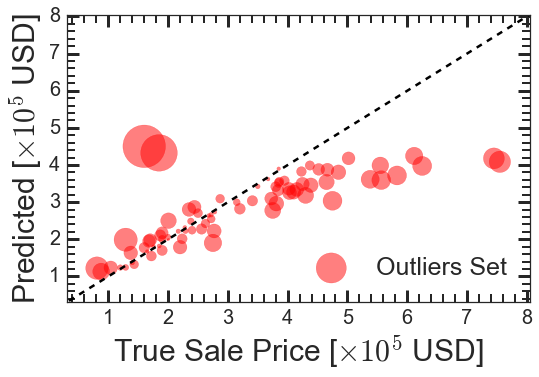

In [22]:
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
#plt.scatter(y_test_data_out_good/1e5, pred_out_good/1e5, alpha = 0.5, 
#            s = 1000*np.abs(y_test_data_out_good-pred_out_good)/y_test_data_out_good, color = 'blue',
#           label ='Test Set')
plt.scatter(y_out/1e5, pred_out/1e5, alpha = 0.5, s = 1000*np.abs(y_out-pred_out)/y_out, color = 'red',
           label ='Outliers Set')
plt.xlabel(r"True Sale Price [$\times 10^{5} $ USD]", fontsize = 30);
plt.ylabel(r"Predicted [$\times 10^{5} $ USD]", fontsize = 30);
plt.minorticks_on()
plt.tight_layout()
plt.plot(np.arange(0,10, 1), np.arange(0,10, 1), 'k--')
plt.tick_params('both', length=8, width=2, which='minor');
plt.tick_params('both', length=12, width=3, which='major');
plt.xlim(min([min(y_out), min(pred_out)])/1e5-0.5, max([max(y_out), max(pred_out)])/1e5+0.5)
plt.ylim(min([min(y_out), min(pred_out)])/1e5-0.5, max([max(y_out), max(pred_out)])/1e5+0.5)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc = 'lower right', fontsize=25)
plt.savefig("FinalModel_linear_out.pdf")

In [23]:
print 'Kaggle\'s log-RMSE score is {:.6f}'.\
format(np.sqrt(np.sum((np.log(y_test_good +1) - np.log(pred_good+1))**2)/len(y_test_good)))
print 'Kaggle\'s log-RMSE score is {:.6f}'.\
format(np.sqrt(np.sum((np.log(y_test_data_out_good +1) - np.log(pred_out_good+1))**2)/len(y_test_data_out_good)))


Kaggle's log-RMSE score is 0.115225
Kaggle's log-RMSE score is 0.149508


The mean is -0.38 and stdev of 17.13


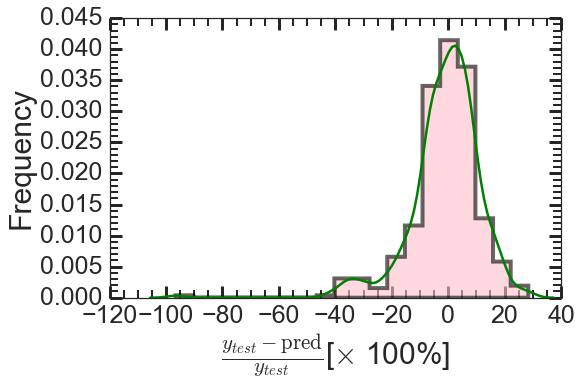

In [24]:
diff_out = (y_test_data_out_good - pred_out_good)/y_test_data_out_good*100.
sns.distplot(diff_good, bins=20, color='g', hist_kws={"histtype": "stepfilled", "linewidth": 4, 
                                                    "alpha": 0.60, "color": "pink"});
plt.xlabel(r"$\frac{y_{test} - \mathrm{pred} }{y_{test}}$" + r"[$ \times $ 100%]", fontsize = 30);
plt.ylabel(r"Frequency", fontsize = 30);
plt.minorticks_on()
plt.tight_layout()
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.tick_params('both', length=8, width=2, which='minor');
plt.tick_params('both', length=12, width=3, which='major');
plt.savefig('FinalDiffDist_linear_out.pdf')

print "The mean is {:.2f} and stdev of {:.2f}".format(np.mean(diff_out), np.std(diff_out))

In [ ]:
## Is there a cluster?
## In log-space
reduced_data = data.copy()
reduced_data.SalePrice = np.log10(reduced_data.SalePrice)
reduced_data.LotArea = np.log10(reduced_data.LotArea)
#reduced_data['GarageArea'] = np.log10(reduced_data['GarageArea'])
reduced_data = reduced_data[['LotArea', 'SalePrice']]

from sklearn import linear_model
reg = linear_model.Lasso(alpha = 0.1)
reg.fit(X_train_good, y_train_good)

In [10]:
from sklearn.mixture import GMM
for n in range(2, 11):
    clusterer = GMM(n_components = n, random_state=143)
    clusterer.fit(reduced_data)
    # Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)
    
    # Find the cluster centers
    centers = clusterer.means_
    
    # Predict the cluster for each transformed sample data point
    #sample_preds = clusterer.predict(pca_samples)
    
    # Calculate the mean silhouette coefficient for the number of clusters chosen
    from sklearn.metrics import silhouette_score
    score = silhouette_score(reduced_data, preds)
    print "For {} clusters we get a silhouette coefficient of {:0.3f}".format(n, score)

For 2 clusters we get a silhouette coefficient of 0.417
For 3 clusters we get a silhouette coefficient of 0.396
For 4 clusters we get a silhouette coefficient of 0.371
For 5 clusters we get a silhouette coefficient of 0.345
For 6 clusters we get a silhouette coefficient of 0.281
For 7 clusters we get a silhouette coefficient of 0.267
For 8 clusters we get a silhouette coefficient of 0.310
For 9 clusters we get a silhouette coefficient of 0.268
For 10 clusters we get a silhouette coefficient of 0.259


TypeError: unhashable type

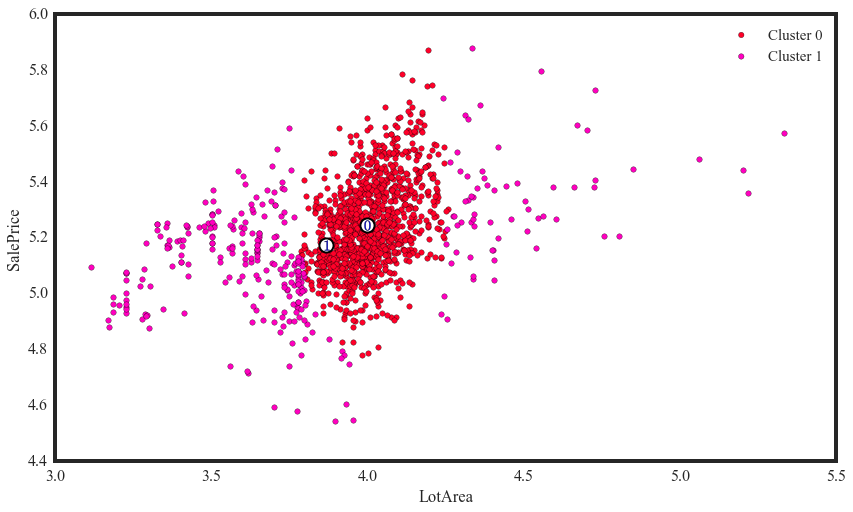

In [11]:
import renders as rs
from sklearn.mixture import GMM
clusterer = GMM(n_components = 2, random_state=143)
clusterer.fit(reduced_data)
# Predict the cluster for each data point
preds = clusterer.predict(reduced_data)

# Find the cluster centers
centers = clusterer.means_

# Predict the cluster for each transformed sample data point
sample_preds = clusterer.predict(samples)

# Display the results of the clustering from implementation

rs.cluster_results(reduced_data, preds, centers, samples)

## Now making predictions on the test.csv set.

(array([   7.,   48.,  119.,   90.,   53.,   39.,   21.,   21.,   12.,    3.]),
 array([  47542.4262376 ,   80612.0630883 ,  113681.699939  ,
         146751.33678969,  179820.97364039,  212890.61049109,
         245960.24734179,  279029.88419249,  312099.52104318,
         345169.15789388,  378238.79474458]),
 <a list of 10 Patch objects>)

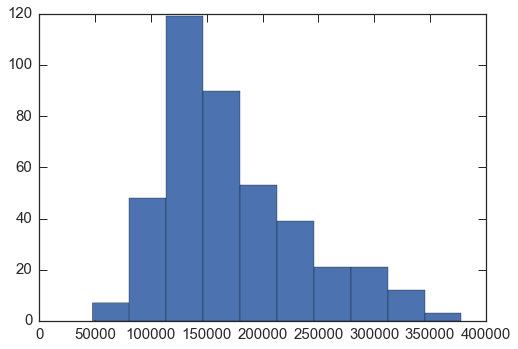

In [25]:
pred_good_test = reg_good.predict(test_X_all)
plt.hist(pred_good)

In [26]:
reg2 = GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='lad',
             max_depth=5, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=5, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             presort='auto', random_state=102345, subsample=1.0, verbose=0,
             warm_start=False)

In [27]:
reg2.fit(X_train_good, y_train_good)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='lad',
             max_depth=5, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=5, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             presort='auto', random_state=102345, subsample=1.0, verbose=0,
             warm_start=False)

In [28]:
pred2 = reg2.predict(X_test_good)
print 'The R$^2$ = {:.2f}'.format(r2_score(pred2, y_test_good))
print 'The  RMSE = {:.2e}.'.format(mean_squared_error(pred2, y_test_good))

The R$^2$ = 0.88
The  RMSE = 4.87e+08.


The mean is -0.96 and stdev of 12.03


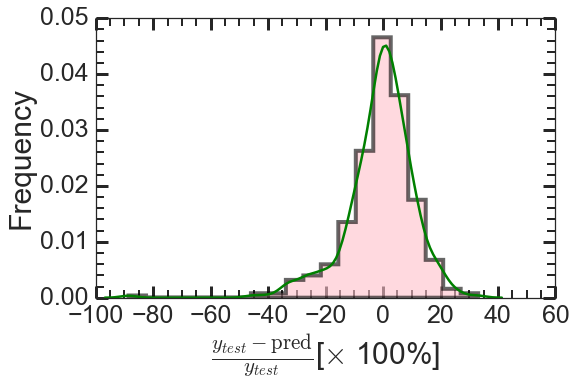

In [29]:
diff_good = (y_test_good - pred2)/y_test_good*100.
sns.distplot(diff_good, bins=20, color='g', hist_kws={"histtype": "stepfilled", "linewidth": 4, 
                                                    "alpha": 0.60, "color": "pink"});
plt.xlabel(r"$\frac{y_{test} - \mathrm{pred} }{y_{test}}$" + r"[$ \times $ 100%]", fontsize = 30);
plt.ylabel(r"Frequency", fontsize = 30);
plt.minorticks_on()
plt.tight_layout()
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.tick_params('both', length=8, width=2, which='minor');
plt.tick_params('both', length=12, width=3, which='major');
plt.savefig('FinalDiffDist_linear_all.pdf')

print "The mean is {:.2f} and stdev of {:.2f}".format(np.mean(diff_good), np.std(diff_good))

In [30]:
print 'Kaggle\'s log-RMSE score is {:.6f}'.\
format(np.sqrt(np.sum((np.log(y_test_good +1) - np.log(pred2+1))**2)/len(y_test_good)))


Kaggle's log-RMSE score is 0.113767


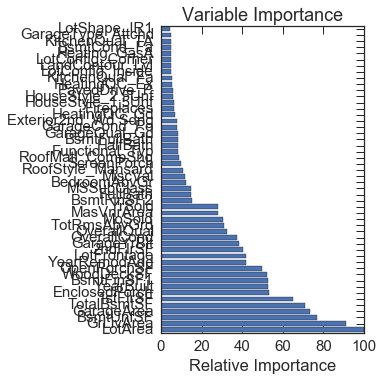

In [31]:
feature_importance = reg2.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(-feature_importance)[0:50]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_test_good.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [32]:
imp_feat = X_test_good.columns[sorted_idx[0:300]]

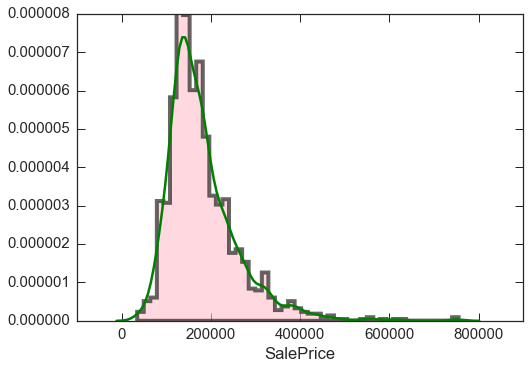

In [57]:
sns.distplot(data['SalePrice'], norm_hist=0, color='g', hist_kws={"histtype": "stepfilled", "linewidth": 4, 
                                                    "alpha": 0.60, "color": "pink"});

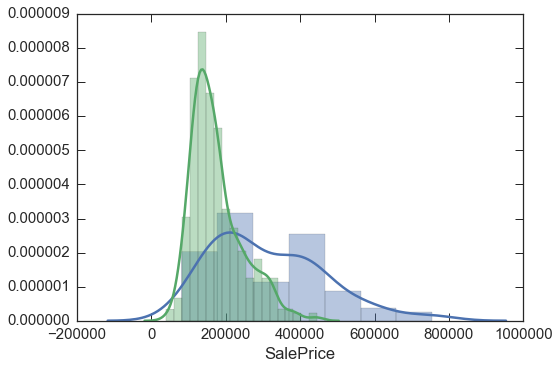

In [60]:
sns.distplot(y_out, bins=100)
sns.distplot(y_test_good)